# Цели и задачи проекта:

### Цель:

Подготовить прототип модели машинного обучения для «Цифры». 

### Задачи:

1. Подготовить и обработать данные 

2. Посмотреть изменение концентрации металлов и суммарную концентрацию

3. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

4. Вычислить показатель sMAPE для разных моделей 

## Подготовьте данные

### Откройте файлы и изучите их

Импортирую библиотеки

In [220]:
import os

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pylab
from scipy import stats as st
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

Открываю файлы

In [221]:
pth1 = 'gold_recovery_train_new.csv'
pth2 = '/datasets/gold_recovery_train_new.csv'

if os.path.exists(pth1):
    gd_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd_train = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [222]:
pth1 = 'gold_recovery_test_new.csv'
pth2 = '/datasets/gold_recovery_test_new.csv'

if os.path.exists(pth1):
    gd_test = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd_test = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [223]:
pth1 = 'gold_recovery_full_new.csv'
pth2 = '/datasets/gold_recovery_full_new.csv'

if os.path.exists(pth1):
    gd_full = pd.read_csv(pth1)
elif os.path.exists(pth2):
    gd_full = pd.read_csv(pth2)
else:
    print('Something is wrong')

Создаю функцию для обзора датасетов

In [224]:
def intro(data):
    print(data.info())
    display(data.head())

Создаём постоянные списки для будущих операций с данными

In [225]:
TARGETS = ['rougher.output.recovery', 'final.output.recovery']
DATA_TARGET = ['date', 'rougher.output.recovery', 'final.output.recovery']
METALS = ['au', 'ag', 'pb']
CONCENTRATE = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
FEED_SIZE = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

Смотрю датасеты

In [226]:
intro(gd_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [227]:
intro(gd_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [228]:
intro(gd_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


В данных видим много различных пропусков и меньше колонок в тестовой выборке.

### Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [229]:
missing_columns = set(gd_train.columns) - set(gd_test.columns)
print(gd_train[missing_columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.tail_au                                14149 non-null  float64
 1   rougher.output.concentrate_sol                      14127 non-null  float64
 2   rougher.calculation.floatbank10_sulfate_to_au_feed  14148 non-null  float64
 3   primary_cleaner.output.concentrate_au               14149 non-null  float64
 4   rougher.output.concentrate_au                       14149 non-null  float64
 5   final.output.concentrate_sol                        13938 non-null  float64
 6   rougher.output.tail_pb                              14149 non-null  float64
 7   secondary_cleaner.output.tail_au                    14149 non-null  float64
 8   primary_cleaner.output.tail_au                      14149 non-null  float64


Отсутсвуют целевые признаки, что абсолютно верно и должно быть.
Кроме этого, отсутвуют столбцы с "output", т.е. параметры готового продукта, что тоже неудивительно, ведь это финальные цифры, которые рассчитываются позже. 

### Проведите предобработку данных.

Добавляем в тестовую выборку целевые показатели

In [230]:
print(gd_test.shape)
gd_test = gd_test.merge(gd_full[DATA_TARGET], on='date', how='left')
print(gd_test.shape)

(5290, 53)
(5290, 55)


Удаляем пропуски в целевых показателях

In [231]:
gd_train = gd_train.dropna(subset=TARGETS)
gd_test = gd_test.dropna(subset=TARGETS)

Заполняем пропуски ближайшими значениями, ведь в ходе преобразований различий у материалов не так много и следующее значение мало отличается от предыдущего. 

In [232]:
gd_train = gd_train.ffill()
gd_test = gd_test.ffill()
gd_full = gd_full.ffill()

### Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Итак, надо подставить в формулу расчёта эффективности необходимые числа из обучающей выборки.

C — доля золота в концентрате после флотации/очистки;

In [233]:
C = gd_train["rougher.output.concentrate_au"]

F — доля золота в сырье/концентрате до флотации/очистки;

In [234]:
F = gd_train["rougher.input.feed_au"]

T — доля золота в отвальных хвостах после флотации/очистки.

In [235]:
T = gd_train["rougher.output.tail_au"]

In [236]:
recovery = (C * (F - T)) / (F * (C - T)) * 100

In [237]:
mae = mean_absolute_error(gd_train['rougher.output.recovery'], recovery)
print(mae)

9.73512347450521e-15


Итоговая ошибка невероятна мала, поэтому можно считать, что результаты в колонке следует считать достоверными.

## Проанализируйте данные

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

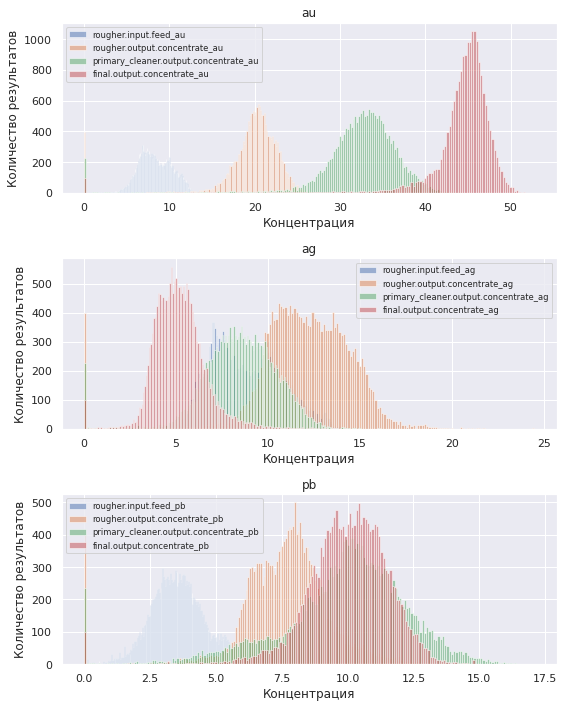

In [238]:
fig, ax = plt.subplots(len(METALS), 1, figsize=(8,10))

for index in range(len(METALS)):
    
    metal = METALS[index]
    metal_concentrate = ['{}_{}'.format(step, metal) for step in CONCENTRATE]
    metal_full = gd_full[metal_concentrate]
    
    for stage in metal_full:
        
        ax[index].hist(metal_full[stage], bins=200, alpha=0.5, label = stage)
        ax[index].set(title=metal, xlabel='Концентрация', ylabel='Количество результатов')
        ax[index].legend(loc='best', fontsize='x-small')
        fig.tight_layout()

У золота логичный постепенный рост концентрации, а вот у остальных металлов такой логики уже нет. Связано это с тем, что золото, как самый дорогой металл, очевидно - цель манипуляций, остальные металлы, если не побочный продукт, то явно не главная цель.

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

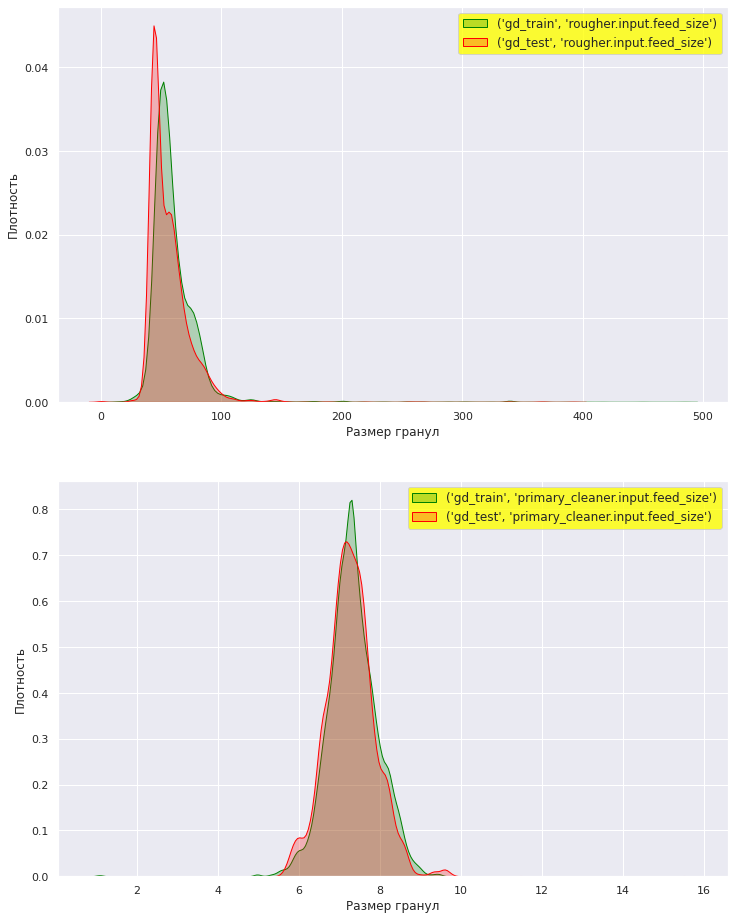

In [239]:
for index in range(len(FEED_SIZE)):
    feed=FEED_SIZE[index]
    pylab.subplot (2, 1, index+1)   
    g=sns.kdeplot(data=gd_train,x=feed, color='green', fill=True, label=('gd_train',feed))
    sns.kdeplot(data=gd_test,x=feed,color='red', fill=True, label=('gd_test',feed))
    g.set(xlabel='Размер гранул', ylabel='Плотность')
    g.legend(loc='best', fontsize=12, facecolor = 'yellow')
    sns.set(rc={'figure.figsize':(12,16)})

Практически идеальное совпадение, значит модель можно считать правильной.

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

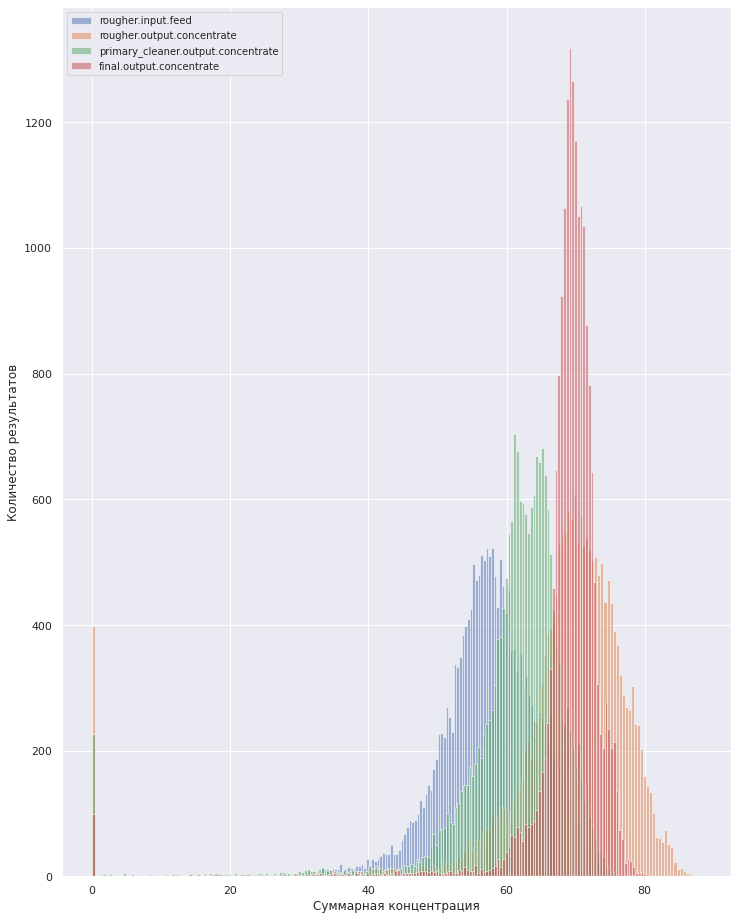

In [240]:
plt.xlabel('Суммарная концентрация')
plt.ylabel('Количество результатов')

for index in range(len(CONCENTRATE)):
    
    stage = CONCENTRATE[index]
    gd_full[stage]=0
    
    for metal in METALS+['sol']:
        
        gd_full[stage] += gd_full['{}_{}'.format(stage, metal)]
        
    plt.hist(gd_full[stage], bins=200, alpha=0.5, label = stage)
    plt.legend(loc='best', fontsize='small')

Как и на прошлых графиках видим столбцы в районе нуля. Скорее всего это аномальные выборосы. проверим на ящике с усами.

count    19439.000000
mean        57.320789
std          7.212680
min          0.040000
25%         53.557679
50%         57.594391
75%         61.953459
max         76.978947
Name: rougher.input.feed, dtype: float64
count    19439.000000
mean        68.170865
std         12.491279
min          0.000000
25%         66.012495
50%         70.181495
75%         74.356904
max         88.140119
Name: rougher.output.concentrate, dtype: float64
count    19439.000000
mean        60.764731
std         10.017271
min          0.000000
25%         58.929364
50%         62.497674
75%         65.667336
max         80.749343
Name: primary_cleaner.output.concentrate, dtype: float64
count    19439.000000
mean        68.653624
std          7.427536
min          0.000000
25%         67.932362
50%         69.598444
75%         71.368472
max         80.210644
Name: final.output.concentrate, dtype: float64


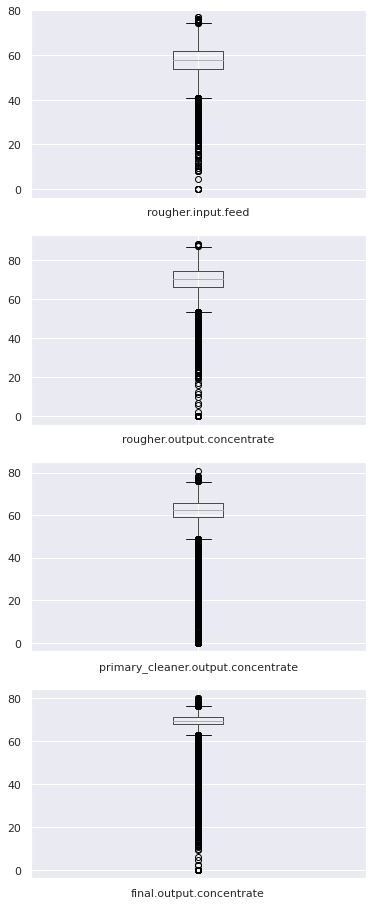

In [241]:
fig, ax = plt.subplots(len(CONCENTRATE), 1, figsize=(6,16))

for index in range(len(CONCENTRATE)):
    
    stage = CONCENTRATE[index]
    gd_full[stage]=0
    
    for metal in METALS+['sol']:
        
        gd_full[stage] += gd_full['{}_{}'.format(stage, metal)]
        
    pylab.subplot (len(CONCENTRATE), 1, index+1)    
    gd_full.boxplot(column=[stage])
    print(gd_full[stage].describe())

Везде минимальное значение - ноль и оно явно выделяется на фоне остального массива. Удалим это значение из стобцов наших выборок.

In [242]:
concentrate =[]

for index in range(len(METALS)):
    
    metal = METALS[index]
    
    for stage in CONCENTRATE:
        
        concentrate.append('{}_{}'.format(stage, metal))
        
    for step in concentrate:
        
        gd_train = gd_train.loc[gd_train[step] > 0]

In [243]:
gd_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13720 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                13720 non-null  object 
 1   final.output.concentrate_ag                         13720 non-null  float64
 2   final.output.concentrate_pb                         13720 non-null  float64
 3   final.output.concentrate_sol                        13720 non-null  float64
 4   final.output.concentrate_au                         13720 non-null  float64
 5   final.output.recovery                               13720 non-null  float64
 6   final.output.tail_ag                                13720 non-null  float64
 7   final.output.tail_pb                                13720 non-null  float64
 8   final.output.tail_sol                               13720 non-null  float64


Выкинули 603 строчки. Это около 4 процентов от первоначальной выборки. Вполне приемлимое значение.

## Постройте модель

Выбрасываем из тренировочной выборке стобцы, которых нет в тестовой.

In [244]:
missing_columns = set(gd_train.columns) - set(gd_test.columns)
gd_train = gd_train.drop(missing_columns, axis=1)
print(gd_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13720 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        13720 non-null  object 
 1   final.output.recovery                       13720 non-null  float64
 2   primary_cleaner.input.sulfate               13720 non-null  float64
 3   primary_cleaner.input.depressant            13720 non-null  float64
 4   primary_cleaner.input.feed_size             13720 non-null  float64
 5   primary_cleaner.input.xanthate              13720 non-null  float64
 6   primary_cleaner.state.floatbank8_a_air      13720 non-null  float64
 7   primary_cleaner.state.floatbank8_a_level    13720 non-null  float64
 8   primary_cleaner.state.floatbank8_b_air      13720 non-null  float64
 9   primary_cleaner.state.floatbank8_b_level    13720 non-null  float64
 10  primary_cl

### Напишите функцию для вычисления итоговой sMAPE.

In [245]:
def smape(target, predictions):
    num = np.abs(target - predictions)
    denom = (np.abs(target) + np.abs(predictions)) / 2 
    return 1 / len(target) * np.sum(num/denom) * 100

def final_smape(target, predictions):
    target_rougher = target['rougher.output.recovery']
    target_final = target['final.output.recovery']
    
    predictions_rougher = predictions[:, 0]
    predictions_final = predictions[:, 1]
    
    rougher_smape = 0.25 * smape(target_rougher, predictions_rougher)
    final_smape = 0.75 * smape(target_final, predictions_final)
    
    return  rougher_smape+final_smape

In [246]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Создадим необходимые выборки

In [247]:
features_train = gd_train.drop(DATA_TARGET,  axis=1)
target_train = gd_train[TARGETS]
features_test = gd_test.drop(DATA_TARGET,  axis=1)
target_test = gd_test[TARGETS]

Масштабируем выборку для линейной регрессии

In [248]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test) 

Решающее дерево 

In [249]:
param_grid = {'max_depth': range(1, 11)}

model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Лучшее значение sMAPE для решающего древа: {-search.best_score_} при значениях гиперпараметров: {search.best_params_}')

Лучшее значение sMAPE для решающего древа: 8.949766802616756 при значениях гиперпараметров: {'max_depth': 1}


Случайный лес

In [250]:
param_grid = {'n_estimators': range(1, 11),
                  'max_depth': range(1, 11)}

model = RandomForestRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
search.fit(features_train, target_train)
print(f'Лучшее значение sMAPE для случайного древа: {-search.best_score_} при значениях гиперпараметров: {search.best_params_}')

Лучшее значение sMAPE для случайного древа: 8.640606910909721 при значениях гиперпараметров: {'max_depth': 3, 'n_estimators': 5}


Линейная регрессия 

In [251]:
model = LinearRegression()
smape_regression = cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer).mean()
print("Среднее sMAPE на тестовой выборке:", -smape_regression)

Среднее sMAPE на тестовой выборке: 10.027250040577737


Как видим, наименьший показатель sMAPE у случайного леса с показателями 3 дерева и глубиной 5.

Смотрим на тестовой выборке

In [254]:
model = RandomForestRegressor(max_depth=3, n_estimators=5, random_state=12345) 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('sMAPE на тестовой выборке:', final_smape(target_test, predictions))

sMAPE на тестовой выборке: 9.363632052482671


Похуже, но всё равно хорошее значение sMAPE.

In [255]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
final_smape(target_test, dummy_model.predict(features_test))

9.828785881311733

Решающее древо и случайный лес показали лучшие результаты, чем дамми-модель со средними арифметическими значениями.

# Общий вывод

1. Подготовить и обработать данные

В ходе данного исследования мы рассмотрели данные, отражающие получение металла из руды.
В данных было много пропусков, которые были заполнены ближайшими значениями из соседних этапов. Отсутсвие некоторого количества колонок в тестовой выборке объясняется задержкой данных. Было добавлено только два целевых стоблца. Отсуствующие в тестовой выборке колонки были удалены из тренировочного датасета.
Концентрация золота 

2. Посмотреть изменение концентрации металлов и суммарную концентрацию

Концентрация золота логично возрастала от этапа к этапу. У других металлов финальная концентрация уступала другим этапам. У серебра вообще худшая концентрация на последнем этапе. Связано это с тем, что золото, как самый дорогой металл, очевидно - цель манипуляций, остальные металлы, если не побочный продукт, то явно не главная цель. Общая концентрация в целом также показывала поэтапный рост, в чём видно влияние золота. Также были обнаружено много выбросов в значениях "0" по концетрации. Их было решено удалить, как подозрительные выбросы. Тем более, их было около 4 процентов от общего количество наблюдений

3. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

Практически идеальное совпадение, значит модель можно считать правильной.

4. Вычислить показатель sMAPE для разных моделей 

Из трёх моделей (решающее древо, случайный лес, линейная регрессия) лучший результат показал метод случайный лес с 5 деревьями и глубиной 3. Она показала sMAPE 2,16%, а на тестовой выборке 2,34%.